# Feature Engineering - part 1

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score

from scipy.stats import boxcox, yeojohnson # for power transformations

In [8]:
with open('data/houses_prepared_encoded.pkl', 'rb') as f:
    houses_train_encoded = pickle.load(f)
    houses_test_encoded = pickle.load(f)

houses_test_encoded.head()

,Order,PID,Lot_Frontage,Lot_Area,Lot_Shape,Land_Slope,Overall_Qual,Overall_Cond,Year_Built,Year_Remod_Add,...,Sale_Type_New,Sale_Type_Other,Sale_Type_WD,Sale_Condition_Family,Sale_Condition_Normal,Sale_Condition_Other,Sale_Condition_Partial,Land_Contour_HLS,Land_Contour_Low,Land_Contour_Lvl
0,1,526301100,141,31770,1.0,0.0,4.0,5.0,1960,1960,...,0,0,1,0,1,0,0,0,0,1
1,2,526350040,80,11622,0.0,0.0,5.0,4.0,1961,1961,...,0,0,1,0,1,0,0,0,0,1
2,3,526351010,81,14267,1.0,0.0,4.0,4.0,1958,1958,...,0,0,1,0,1,0,0,0,0,1
3,4,526353030,93,11160,0.0,0.0,3.0,5.0,1968,1968,...,0,0,1,0,1,0,0,0,0,1
4,5,527105010,74,13830,1.0,0.0,5.0,5.0,1997,1998,...,0,0,1,0,1,0,0,0,0,1


In [10]:
# remember that on classes related to variable selection methods
# we created a subset of variables -- SELECTED predictors
# - 12 numerical most correlated with the target
# - 13 categorical most related (ANOVA) with the target

# and saved them into a pickle file

with open('data/houses_selected_vars.pkl', 'rb') as f:
    houses_selected_vars = pickle.load(f)

print(houses_selected_vars)

['Gr_Liv_Area', 'Garage_Area', 'Total_Bsmt_SF', 'Full_Bath', 'Year_Built', 'Year_Remod_Add', 'Fireplaces', 'Wood_Deck_SF', 'Half_Bath', 'Open_Porch_SF', 'Bsmt_Full_Bath', 'Lot_Area', 'Exter_Qual', 'Kitchen_Qual', 'Bsmt_Qual', 'Garage_Finish', 'Fireplace_Qu', 'Foundation', 'Central_Air', 'Mas_Vnr_Type', 'Heating_QC', 'Bsmt_Exposure', 'Neighborhood', 'BsmtFin_Type_1', 'Sale_Type']


## Transformation of the outcome (Y) variable in regression

In [13]:
# lets remind the prediction accuracy of the simple linear regression model 
# estimated on all variables

houses_train_X_all = houses_train_encoded.drop(['Sale_Price', 'Order', 'PID'], axis = 1)
houses_train_Y = houses_train_encoded['Sale_Price']

houses_lm0_all = LinearRegression().fit(houses_train_X_all, houses_train_Y)

In [17]:
# linear model using only SELECTED variables

# Automatically select all columns that start with any selected predictor name
# the reason for doing this is because after encoding columns are increased

houses_selected_vars_encoded = [
    col for col in houses_train_encoded.columns
    if any(col.startswith(prefix) for prefix in houses_selected_vars)
]

houses_train_X_sel = houses_train_encoded[houses_selected_vars_encoded]

houses_lm1_selected = LinearRegression().fit(houses_train_X_sel, houses_train_Y)

<Axes: xlabel='Sale_Price', ylabel='Count'>

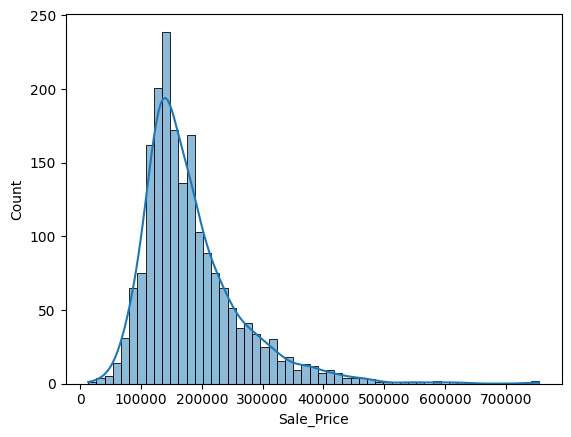

In [19]:
# lets remind the distribution of the outcome variable
# (we check JUST THE TRAINING DATA)

sns.histplot(
    houses_train_encoded['Sale_Price'], 
    kde = True
)

<Axes: xlabel='Sale_Price', ylabel='Count'>

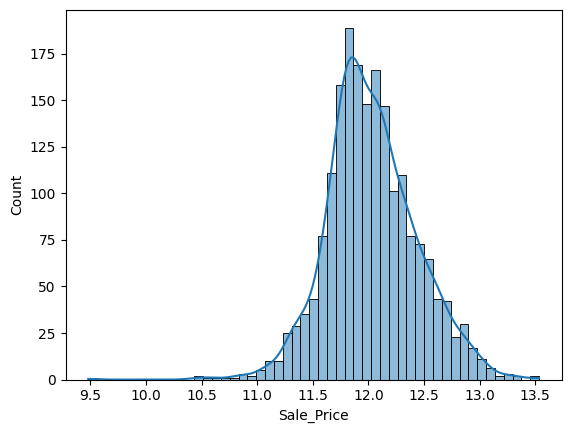

In [21]:
# clearly right-skewed distribution 
# let's see how it looks after log-transformation
# we use log(x + 1) in case of zeros in X

# Histogram of the log-transformed Sale_Price

sns.histplot(
    np.log(houses_train_encoded['Sale_Price'] + 1),
    kde = True
)

In [31]:
# lets apply the log-linear model on all variables

houses_train_Y_log = np.log(houses_train_encoded['Sale_Price'] + 1)

houses_lm2_all_log = LinearRegression().fit(houses_train_X_all, houses_train_Y_log)

In [33]:
# and a log-linear model on selected variables

houses_lm3_selected_log = LinearRegression().fit(houses_train_X_sel, houses_train_Y_log)

In [35]:
# lets generate predicted values on the training sample from all models

houses_pred_train = pd.DataFrame()

houses_pred_train['houses_lm0_all'] = houses_lm0_all.predict(houses_train_X_all)
houses_pred_train['houses_lm1_selected'] = houses_lm1_selected.predict(houses_train_X_sel)
houses_pred_train['houses_lm2_all_log'] = houses_lm2_all_log.predict(houses_train_X_all)
houses_pred_train['houses_lm3_selected_log']=houses_lm3_selected_log.predict(houses_train_X_sel)

houses_pred_train.head()

,houses_lm0_all,houses_lm1_selected,houses_lm2_all_log,houses_lm3_selected_log
0,209698.564969,198556.540825,12.201026,12.143460
1,247103.078191,214301.244505,12.434751,12.265035
2,188915.823020,202764.710075,12.105485,12.161049
3,164639.516790,165545.531532,12.059598,12.075072
4,159341.518932,162556.256752,12.040826,12.059122


### reverse logged values to normal value

---

In [37]:
# remember that models lm2 and lm3 operated on transformed prices.
# To calculate the real fitted value of these models one should reverse the 
# transformation of the target variable
# if y2 = ln(y + 1) then y = exp (y2) - 1

houses_pred_train['houses_lm2_all_log'] = np.exp(houses_pred_train['houses_lm2_all_log'])-1
houses_pred_train['houses_lm3_selected_log'] = np.exp(houses_pred_train['houses_lm3_selected_log'])-1

houses_pred_train.head()

,houses_lm0_all,houses_lm1_selected,houses_lm2_all_log,houses_lm3_selected_log
0,209698.564969,198556.540825,198992.177909,187860.443797
1,247103.078191,214301.244505,251386.543953,212145.972733
2,188915.823020,202764.710075,180860.244265,191193.927297
3,164639.516790,165545.531532,172748.504331,175442.461335
4,159341.518932,162556.256752,169535.912823,172666.265845


In [41]:
# in the same way we apply the models to generate predictions on the test sample

houses_test_X_all = houses_test_encoded.drop(['Sale_Price', 'Order', 'PID'], axis = 1)
houses_test_X_sel = houses_test_encoded[houses_selected_vars_encoded]

houses_pred_test = pd.DataFrame()

houses_pred_test['houses_lm0_all'] = houses_lm0_all.predict(houses_test_X_all)
houses_pred_test['houses_lm1_selected'] = houses_lm1_selected.predict(houses_test_X_sel)
houses_pred_test['houses_lm2_all_log'] = houses_lm2_all_log.predict(houses_test_X_all)
houses_pred_test['houses_lm3_selected_log'] = houses_lm3_selected_log.predict(houses_test_X_sel)

# reverse the transformation of the target variable (Y)
# y2 = ln(y + 1), y = exp(y2) - 1

houses_pred_test['houses_lm2_all_log'] = np.exp(houses_pred_test['houses_lm2_all_log']) -1
houses_pred_test['houses_lm3_selected_log'] = np.exp(houses_pred_test['houses_lm3_selected_log']) - 1

houses_pred_test.head()

,houses_lm0_all,houses_lm1_selected,houses_lm2_all_log,houses_lm3_selected_log
0,211353.461548,197047.483813,187454.793327,176566.286814
1,102244.437601,115510.603566,107604.082835,121785.587698
2,129548.951723,151586.896966,133030.032833,141864.878946
3,263180.830346,258517.356843,240456.759403,246629.133877
4,166051.421847,177188.345145,164568.906149,184157.697901


In [43]:
# lets compare the quality of these forecasts
# using the function we created on one of the previous labs

from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.metrics import mean_squared_error, r2_score

def regression_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    return {
        'RMSE': rmse,
        'MAE': mae,
        'MedAE': medae,
        'MAPE': mape,
        'R2': r2
    }

In [49]:
# apply the function to the training data predictions to calculate 
# all performance metrics

houses_train_metrics = pd.DataFrame()

for col in houses_pred_train.columns:
    houses_train_metrics[col] = regression_metrics(
        houses_train_Y, houses_pred_train[col]
    )

houses_train_metrics

# models on transformed outcome variable (Y) 
# seem to (generally) work better in the training sample!

,houses_lm0_all,houses_lm1_selected,houses_lm2_all_log,houses_lm3_selected_log
RMSE,27548.016693,31959.000580,26174.510368,34648.157324
MAE,17112.735024,20086.938784,14477.631349,17752.531576
MedAE,11949.157615,14168.275102,9203.696260,11752.492932
MAPE,49.021559,48.039007,48.042253,46.843998
R2,0.882560,0.841940,0.893979,0.814222


In [51]:
# lets compare the test data

houses_test_metrics = pd.DataFrame()

for col in houses_pred_test.columns:
    houses_test_metrics[col] = regression_metrics(
        houses_test_encoded['Sale_Price'], houses_pred_test[col]
    )

houses_test_metrics
# which is confirmed on the test data

,houses_lm0_all,houses_lm1_selected,houses_lm2_all_log,houses_lm3_selected_log
RMSE,26943.430838,30342.092189,24695.149679,27262.968781
MAE,18296.201895,20805.012774,16226.565352,18608.896848
MedAE,13341.442153,15091.415136,11011.256100,12898.278196
MAPE,11.575324,13.269374,9.715010,11.897134
R2,0.883088,0.851733,0.901785,0.880298


## Power Transformations

In [56]:
# lets try to apply Box-Cox transformation for Sale_Price
# (Sale_Price must be > 0)

# Apply Box-Cox and get the optimal lambda
# (optimized if you do not provide the lambda= argument)
sale_price_boxcox, fitted_lambda = boxcox(houses_train_encoded['Sale_Price'])

print(fitted_lambda)

-0.040902761401480844


In [58]:
# add transformed column to dataframe
houses_train_encoded['Sale_Price_boxcox'] = sale_price_boxcox

# !!! if lambda is close to 0, you may use log transformation instead

# To invert the Box-Cox transformation (to go back to original values), use:
# from scipy.special import inv_boxcox
# inv_boxcox(transformed_values, fitted_lambda)

# check the first few rows of the transformed column
print(houses_train_encoded['Sale_Price_boxcox'].head())

989    9.532617
990    9.712625
991    9.629255
992    9.569456
993    9.491455
Name: Sale_Price_boxcox, dtype: float64


In [60]:
# we can also check the Yeo-Johnson's transformation
# (can handle 0 and negative values)

sale_price_yeojohnson, fitted_lambda2 = yeojohnson(houses_train_encoded['Sale_Price'])

print(fitted_lambda2)

# if needed, add transformed values to the DataFrame
houses_train_encoded['Sale_Price_yeojohnson'] = sale_price_yeojohnson

# in this case it is almost the same transformation
# as in Box-Cox, so we can skip it

-0.04091355251520589


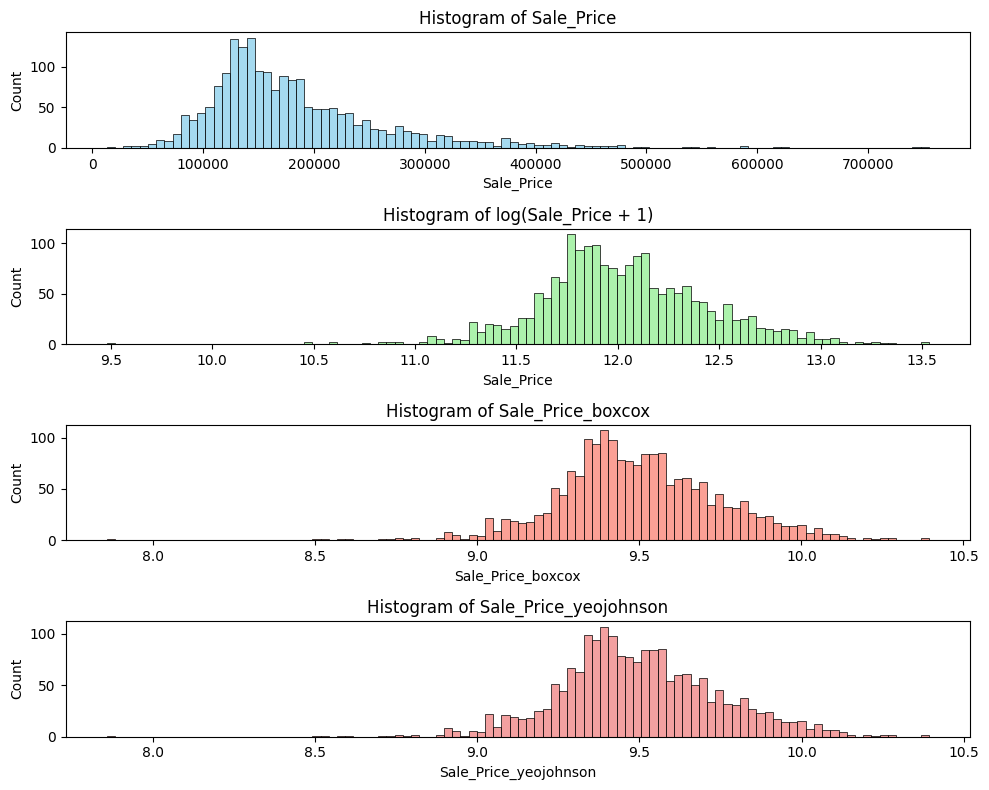

In [64]:
# lets compare the histogram of the values
# before and after all transformations

# set up a 4-row vertical layout
fig, axs = plt.subplots(4, 1, figsize = (10, 8)) # 4 rows, 1 column

# first histogram: original Sale_Price
sns.histplot(
    houses_train_encoded['Sale_Price'],
    bins = 100,
    ax = axs[0],
    color = 'skyblue'
)
axs[0].set_title('Histogram of Sale_Price')

# second histogram: log-transformed Sale_Price
sns.histplot(
    np.log(houses_train_encoded['Sale_Price'] + 1),
    bins = 100,
    ax = axs[1],
    color = 'lightgreen'
)
axs[1].set_title('Histogram of log(Sale_Price + 1)')

# third histogram: Box-Cox transformed Sale_Price
sns.histplot(
    houses_train_encoded['Sale_Price_boxcox'],
    bins = 100,
    ax = axs[2],
    color = 'salmon'
)
axs[2].set_title('Histogram of Sale_Price_boxcox')

# fourth histogram: Yeo-Johnson transformed Sale_Price
sns.histplot(
    houses_train_encoded['Sale_Price_yeojohnson'],
    bins = 100,
    ax = axs[3],
    color = 'lightcoral'
)
axs[3].set_title('Histogram of Sale_Price_yeojohnson')

plt.tight_layout()
plt.show()

# here results of the Box-Cox (Yeo-Johnson) and 
# Log-transformation are very similar
# so we prefer to use the simple one (log)
# - remember that optimal lambda here is close to 0

<Axes: xlabel='Lot_Area', ylabel='Count'>

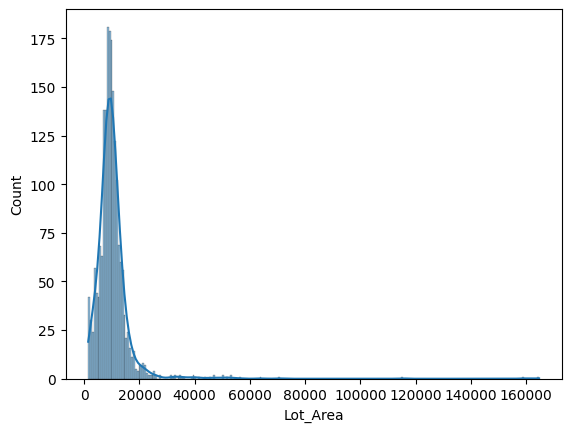

In [68]:
# CAUTION!
# Generally the Box-Cox and Yeo-Johnson transformations were designed to be used for
# outcome variables (Y), but one can try to apply these transformations also to 
# Predictor Variables (Xi)


# lets check the distribution of Lot_Area
sns.histplot(
    houses_train_encoded['Lot_Area'],
    kde = True
)

# one can consider log or Box-Cox transformation

<Axes: xlabel='Lot_Area', ylabel='Count'>

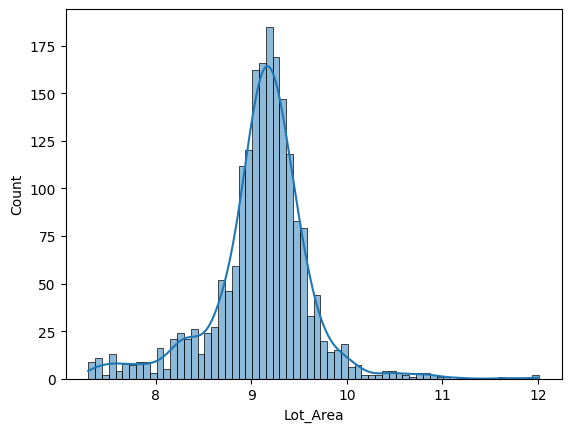

In [72]:
# Histogram of the log-transformed Lot_Area + 1

sns.histplot(
    np.log(houses_train_encoded['Lot_Area'] + 1),
    kde = True
)

# CAUTION!
# For predictor variables (Xi), the Box-Cox/Yeo-Johnson transformation has to be applied
# also on the Test data

# For test set, use the same lambda (no re-fitting !!!), ex:
# houses_test_encoded['Lot_Area_boxcox'] = boxcox(houses_test_encoded['Lot_Area'],
#                                                 lambda = fitted_lambda)

# (NOT optimized if you DO provide the lambda= argument)